## 01. Preprocess Each Image to Detect Lines

### a. Load and Binarize the Image

In [2]:
import cv2
# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/sentences.jpeg', cv2.IMREAD_GRAYSCALE)

# Binarize the image
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Display the binarized image using OpenCV
cv2.imshow('Binarized Image', binary_image)

# Wait for a key press and then close the displayed window
cv2.waitKey(0)
cv2.destroyAllWindows()

### b. Detect Horizontal Lines

In [3]:
# Use morphology operations to detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
detected_lines = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

# Find contours of the lines
line_contours, _ = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

### c. Extract Bounding Boxes from Each Line

In [4]:
line_images = []
for contour in line_contours:
    x, y, w, h = cv2.boundingRect(contour)
    line_image = binary_image[y:y+h, x:x+w]
    line_images.append((line_image, y))


## 02. Segment Each Line into Characters

### a. Line/Character Segmentation

#### Trial 01: Line/Character Segmentation - FAILED

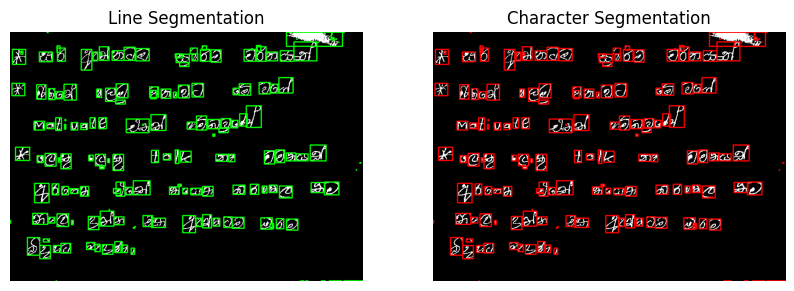

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/sentences.jpeg', cv2.IMREAD_GRAYSCALE)

# Binarize the image
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours for line segmentation
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw bounding boxes
line_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# Draw bounding boxes around lines
line_bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    line_bounding_boxes.append((x, y, w, h))
    cv2.rectangle(line_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Create a copy of the image to draw bounding boxes
character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# Draw bounding boxes around characters within each line
for x, y, w, h in line_bounding_boxes:
    line_roi = binary_image[y:y+h, x:x+w]
    char_contours, _ = cv2.findContours(line_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for char_contour in char_contours:
        cx, cy, cw, ch = cv2.boundingRect(char_contour)
        cv2.rectangle(character_image, (x+cx, y+cy), (x+cx+cw, y+cy+ch), (255, 0, 0), 2)

# Display the images using Matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(line_image)
plt.title('Line Segmentation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(character_image)
plt.title('Character Segmentation')
plt.axis('off')

plt.show()


#### Trial 02: Dilation + Line/Character Segmentation - FAILED

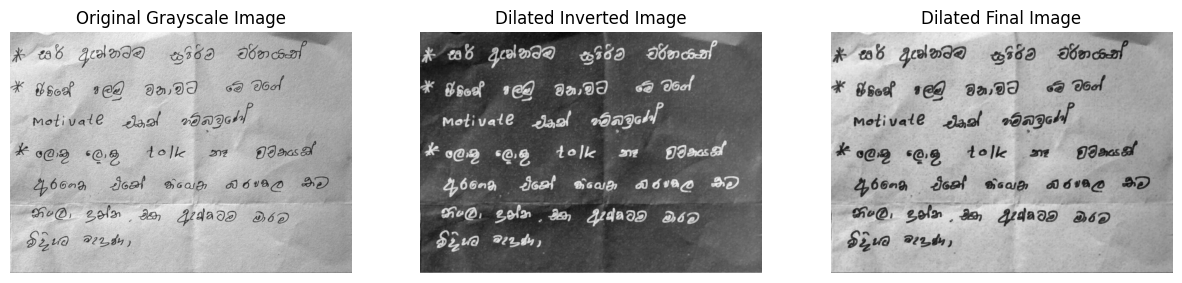

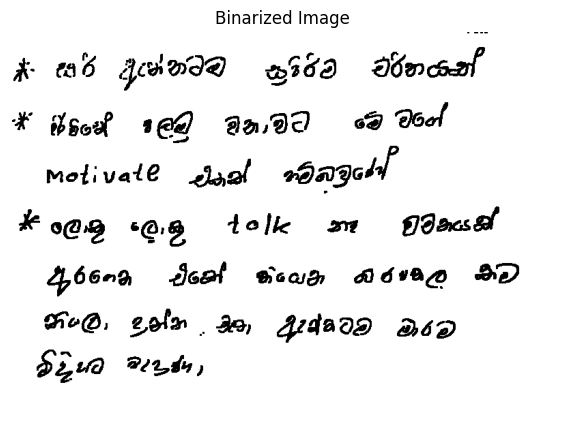

Number of contours found: 1
Number of bounding boxes found: 1
565
565


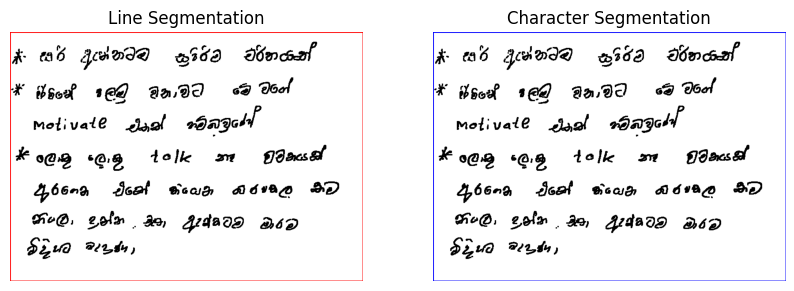

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/sentences.jpeg', cv2.IMREAD_GRAYSCALE)

# Invert the image so the text becomes white and background becomes black
inverted_image = cv2.bitwise_not(image)

# Define a 3x3 kernel
kernel = np.ones((3, 3), np.uint8)

# Perform dilation on the inverted image
dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

# Invert back to original colors (if needed)
final_image = cv2.bitwise_not(dilated_image)

# Display the images using Matplotlib
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilated Inverted Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_image, cmap='gray')
plt.title('Dilated Final Image')
plt.axis('off')

plt.show()

# Apply binarization with a threshold of 112 (adjust this value as needed)
_, binarized_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY)

# Display the binarized image to verify contours are detectable
plt.figure(figsize=(10, 5))
plt.imshow(binarized_image, cmap='gray')
plt.title('Binarized Image')
plt.axis('off')
plt.show()

# Find contours for character segmentation
char_contours, _ = cv2.findContours(binarized_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Debug: Print number of contours found
print(f'Number of contours found: {len(char_contours)}')

# Create a copy of the image to draw bounding boxes
line_image = cv2.cvtColor(binarized_image, cv2.COLOR_GRAY2BGR)
character_image = cv2.cvtColor(binarized_image, cv2.COLOR_GRAY2BGR)

# List to store character bounding boxes
char_bounding_boxes = []
for contour in char_contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Relaxed size filters for debugging
    if w > 3 and h > 3:
        char_bounding_boxes.append((x, y, w, h))

# Debug: Print number of bounding boxes found
print(f'Number of bounding boxes found: {len(char_bounding_boxes)}')

# Sort the bounding boxes by the y-coordinate to help group them into lines
char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

# Group characters into lines
lines = []
current_line = []
line_threshold = 100  # Adjust this value to control line detection sensitivity

for i, box in enumerate(char_bounding_boxes):
    if i == 0:
        current_line.append(box)
    else:
        # Check if the current character is on the same line as the previous one
        prev_box = char_bounding_boxes[i - 1]
        if abs(box[1] - prev_box[1]) < line_threshold:  # Same line (within threshold)
            current_line.append(box)
        else:
            # New line detected
            lines.append(current_line)
            current_line = [box]

# Add the last line
if current_line:
    lines.append(current_line)

# Draw bounding boxes for each character and line
for line in lines:
    # Sort characters within the line from left to right
    line = sorted(line, key=lambda box: box[0])
    for (x, y, w, h) in line:
        # Draw character bounding boxes in blue
        cv2.rectangle(character_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Draw line bounding box in red
    x_min = min([box[0] for box in line])
    y_min = min([box[1] for box in line])
    x_max = max([box[0] + box[2] for box in line])
    y_max = max([box[1] + box[3] for box in line])
    cv2.rectangle(line_image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

# Display the image with bounding boxes around lines and characters
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Line Segmentation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
plt.title('Character Segmentation')
plt.axis('off')

print(len(line_image))
print(len(character_image))

plt.show()



#### Trial 03: Line/Character Segmentation - SUCCESS

565
565


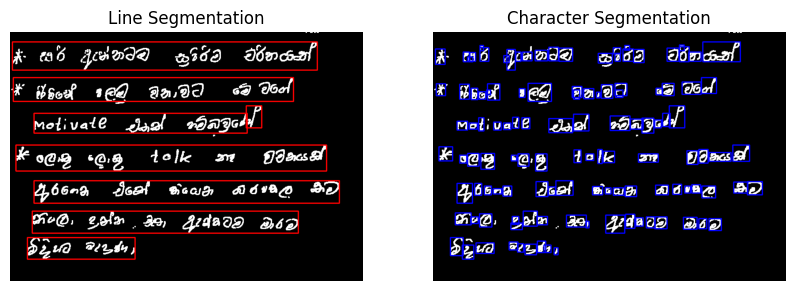

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/sentences.jpeg', cv2.IMREAD_GRAYSCALE)

# ----------------------------------------------------------------
# Invert the image so the text becomes white and background becomes black
inverted_image = cv2.bitwise_not(image)

# Define a 3x3 kernel
kernel = np.ones((3, 3), np.uint8)

# Perform dilation on the inverted image
dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

# Invert back to original colors (if needed)
final_image = cv2.bitwise_not(dilated_image)
# ----------------------------------------------------------------

# Binarize the image with a higher threshold to reduce sensitivity
_, binary_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY_INV)

# Find contours for character segmentation with a more aggressive approximation method
char_contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw bounding boxes
line_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# List to store character bounding boxes
char_bounding_boxes = []
for contour in char_contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Filter out small contours to reduce sensitivity
    if w > 6 and h > 10:
        char_bounding_boxes.append((x, y, w, h))

# Sort the bounding boxes by the y-coordinate to help group them into lines
char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

# Group characters into lines
lines = []
current_line = []
line_threshold = 14  # Adjust this value to control line detection sensitivity

for i, box in enumerate(char_bounding_boxes):
    if i == 0:
        current_line.append(box)
    else:
        # Check if the current character is on the same line as the previous one
        prev_box = char_bounding_boxes[i - 1]
        if abs(box[1] - prev_box[1]) < line_threshold:  # Same line (within threshold)
            current_line.append(box)
        else:
            # New line detected
            lines.append(current_line)
            current_line = [box]

# Add the last line
if current_line:
    lines.append(current_line)

# Draw bounding boxes for each character and line
for line in lines:
    # Sort characters within the line from left to right
    line = sorted(line, key=lambda box: box[0])
    for (x, y, w, h) in line:
        # Draw character bounding boxes in blue
        cv2.rectangle(character_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Draw line bounding box in red
    x_min = min([box[0] for box in line])
    y_min = min([box[1] for box in line])
    x_max = max([box[0] + box[2] for box in line])
    y_max = max([box[1] + box[3] for box in line])
    cv2.rectangle(line_image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

# Display the image with bounding boxes around lines and characters
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Line Segmentation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
plt.title('Character Segmentation')
plt.axis('off')

print(len(line_image))
print(len(character_image))
plt.show()


### b. Cropping from Contours and Displaying the Identified Letters - SUCCESS!!

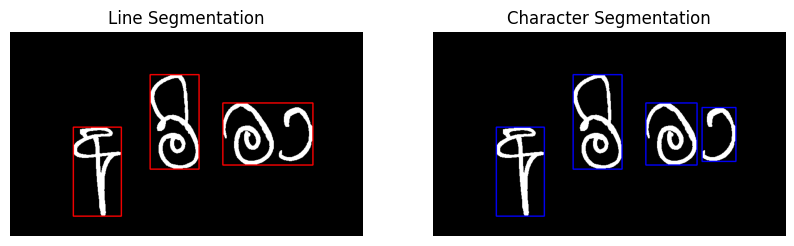

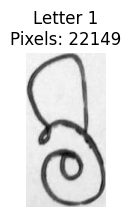

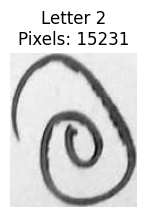

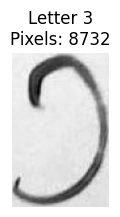

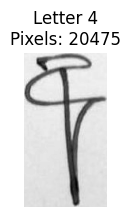

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/amma_cropped.jpg', cv2.IMREAD_GRAYSCALE)

# ----------------------------------------------------------------
# Invert the image so the text becomes white and background becomes black
inverted_image = cv2.bitwise_not(image)

# Define a 3x3 kernel
kernel = np.ones((3, 3), np.uint8)

# Perform dilation on the inverted image
dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

# Invert back to original colors (if needed)
final_image = cv2.bitwise_not(dilated_image)
# ----------------------------------------------------------------

# Binarize the image with a higher threshold to reduce sensitivity
_, binary_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY_INV)

# Find contours for character segmentation with a more aggressive approximation method
char_contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw bounding boxes
line_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# List to store character bounding boxes
char_bounding_boxes = []
for contour in char_contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Filter out small contours to reduce sensitivity
    if w > 6 and h > 10:
        char_bounding_boxes.append((x, y, w, h))

# Sort the bounding boxes by the y-coordinate to help group them into lines
char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

# Group characters into lines
lines = []
current_line = []
line_threshold = 14  # Adjust this value to control line detection sensitivity

for i, box in enumerate(char_bounding_boxes):
    if i == 0:
        current_line.append(box)
    else:
        # Check if the current character is on the same line as the previous one
        prev_box = char_bounding_boxes[i - 1]
        if abs(box[1] - prev_box[1]) < line_threshold:  # Same line (within threshold)
            current_line.append(box)
        else:
            # New line detected
            lines.append(current_line)
            current_line = [box]

# Add the last line
if current_line:
    lines.append(current_line)

# Draw bounding boxes for each character and line
for line in lines:
    # Sort characters within the line from left to right
    line = sorted(line, key=lambda box: box[0])
    for (x, y, w, h) in line:
        # Draw character bounding boxes in blue
        cv2.rectangle(character_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Draw line bounding box in red
    x_min = min([box[0] for box in line])
    y_min = min([box[1] for box in line])
    x_max = max([box[0] + box[2] for box in line])
    y_max = max([box[1] + box[3] for box in line])
    cv2.rectangle(line_image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

# Display the image with bounding boxes around lines and characters
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Line Segmentation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
plt.title('Character Segmentation')
plt.axis('off')

plt.show()

# Crop each letter and display them
for i, (x, y, w, h) in enumerate(char_bounding_boxes):
    # Crop the letter from the original image
    letter_crop = image[y:y+h, x:x+w]
    
    # Calculate number of pixels in the cropped region
    num_pixels = np.sum(letter_crop > 0)  # Count non-zero pixels
    
    # Display the cropped letter with the number of pixels
    plt.figure(figsize=(2, 2))
    plt.imshow(letter_crop, cmap='gray')
    plt.title(f'Letter {i+1}\nPixels: {num_pixels}')
    plt.axis('off')
    plt.show()


### c. Cropping from Contours and Resizing - SUCCESS!!

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/sentences.jpeg', cv2.IMREAD_GRAYSCALE)

# ----------------------------------------------------------------
# Invert the image so the text becomes white and background becomes black
inverted_image = cv2.bitwise_not(image)

# Define a 3x3 kernel
kernel = np.ones((3, 3), np.uint8)

# Perform dilation on the inverted image
dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

# Invert back to original colors (if needed)
final_image = cv2.bitwise_not(dilated_image)
# ----------------------------------------------------------------

# Binarize the image with a higher threshold to reduce sensitivity
_, binary_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY_INV)

# Find contours for character segmentation with a more aggressive approximation method
char_contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw bounding boxes
line_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# List to store character bounding boxes
char_bounding_boxes = []
for contour in char_contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Filter out small contours to reduce sensitivity
    if w > 6 and h > 10:
        char_bounding_boxes.append((x, y, w, h))

# Sort the bounding boxes by the y-coordinate to help group them into lines
char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

# Group characters into lines
lines = []
current_line = []
line_threshold = 14  # Adjust this value to control line detection sensitivity

for i, box in enumerate(char_bounding_boxes):
    if i == 0:
        current_line.append(box)
    else:
        # Check if the current character is on the same line as the previous one
        prev_box = char_bounding_boxes[i - 1]
        if abs(box[1] - prev_box[1]) < line_threshold:  # Same line (within threshold)
            current_line.append(box)
        else:
            # New line detected
            lines.append(current_line)
            current_line = [box]

# Add the last line
if current_line:
    lines.append(current_line)

# Draw bounding boxes for each character and line
for line in lines:
    # Sort characters within the line from left to right
    line = sorted(line, key=lambda box: box[0])
    for (x, y, w, h) in line:
        # Draw character bounding boxes in blue
        cv2.rectangle(character_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Draw line bounding box in red
    x_min = min([box[0] for box in line])
    y_min = min([box[1] for box in line])
    x_max = max([box[0] + box[2] for box in line])
    y_max = max([box[1] + box[3] for box in line])
    cv2.rectangle(line_image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

# Display the image with bounding boxes around lines and characters
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Line Segmentation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
plt.title('Character Segmentation')
plt.axis('off')

plt.show()

# Crop, resize each letter to 80x80 pixels, and display them
for i, (x, y, w, h) in enumerate(char_bounding_boxes):
    # Crop the letter from the original image
    letter_crop = image[y:y+h, x:x+w]
    
    # Calculate number of pixels in the cropped region
    num_pixels = np.sum(letter_crop > 0)  # Count non-zero pixels

    # Display the cropped letter with the number of pixels
    plt.figure(figsize=(2, 2))
    plt.imshow(letter_crop, cmap='gray')
    plt.title(f'Original Letter {i+1}\nPixels: {num_pixels}')
    plt.axis('off')
    plt.show()
    
    # Resize the cropped letter to 80x80 pixels
    resized_letter = cv2.resize(letter_crop, (80, 80), interpolation=cv2.INTER_AREA)
    # Calculate number of pixels in the resized region
    num_pixels_resized = np.sum(resized_letter > 0)  # Count non-zero pixels

    # Display the resized letter
    plt.figure(figsize=(2, 2))
    plt.imshow(resized_letter, cmap='gray')
    plt.title(f'Resized Letter {i+1} Pixels: {num_pixels_resized}')
    plt.axis('off')
    plt.show()


## 03. Store and Display Characters in the Correct Order

#### Trial 01: With Sample Image - Unsuccessfull

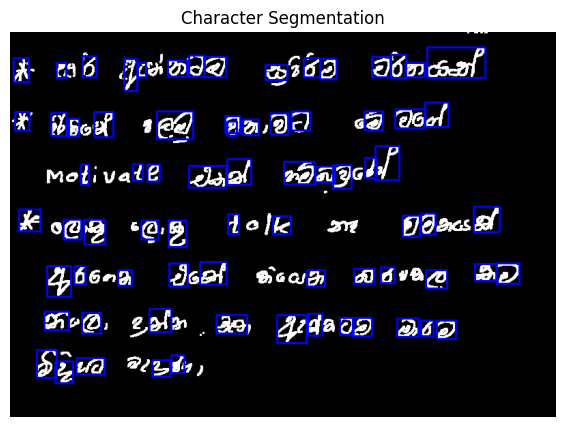

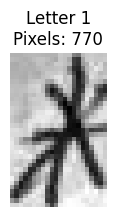

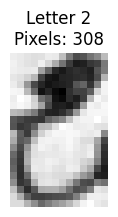

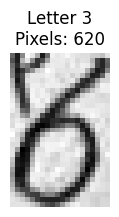

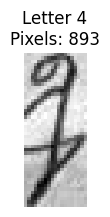

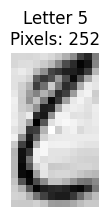

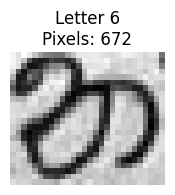

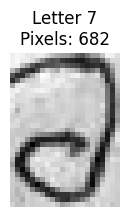

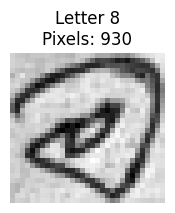

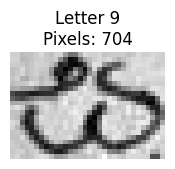

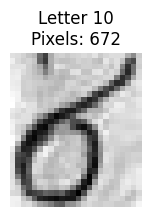

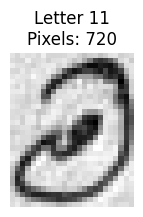

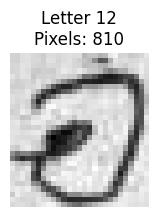

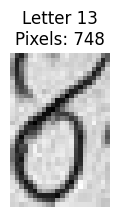

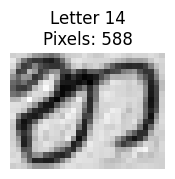

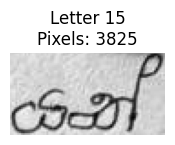

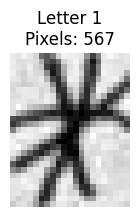

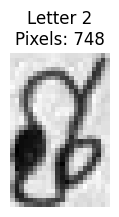

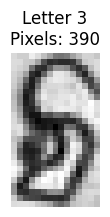

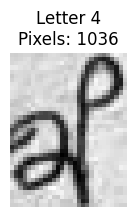

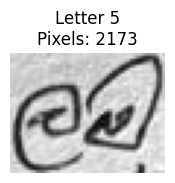

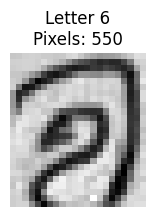

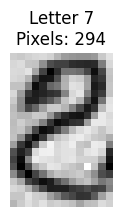

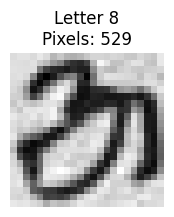

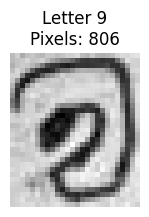

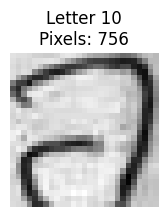

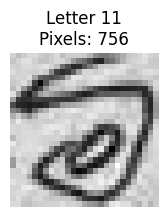

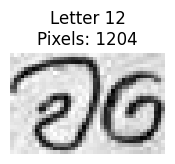

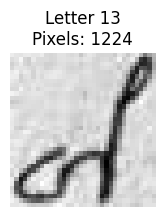

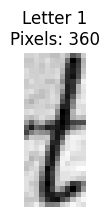

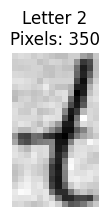

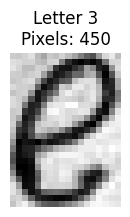

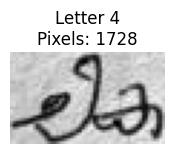

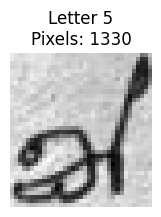

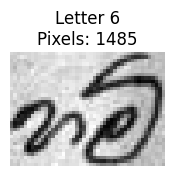

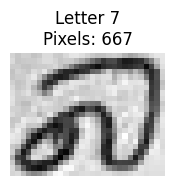

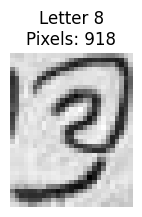

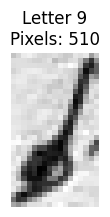

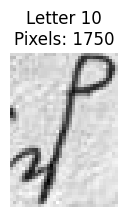

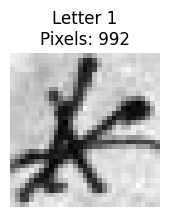

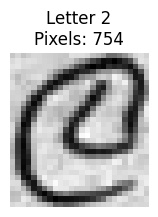

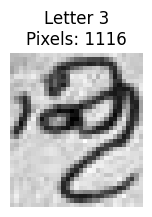

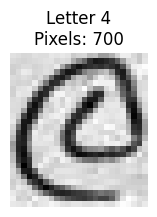

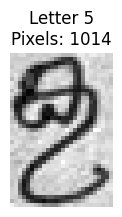

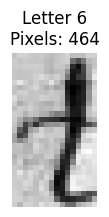

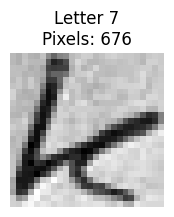

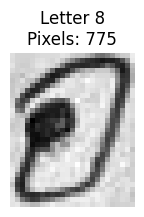

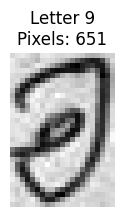

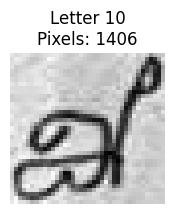

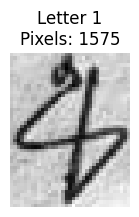

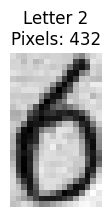

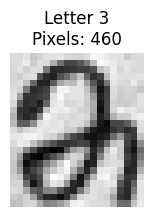

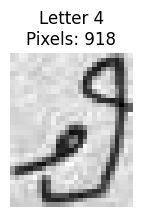

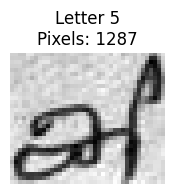

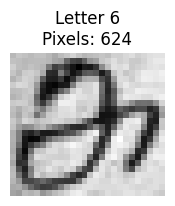

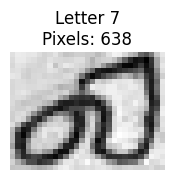

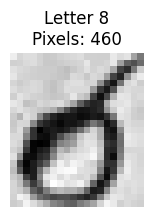

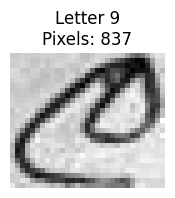

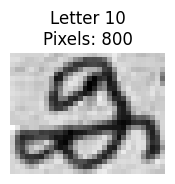

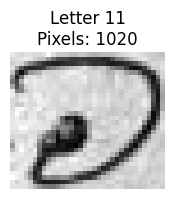

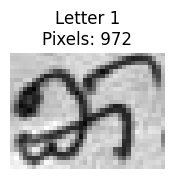

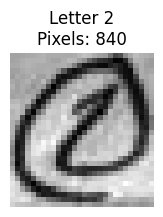

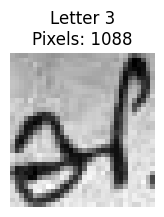

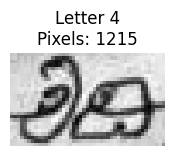

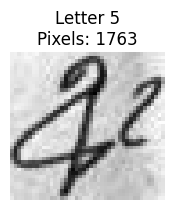

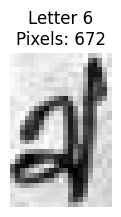

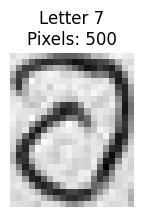

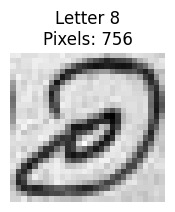

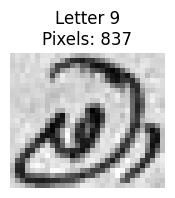

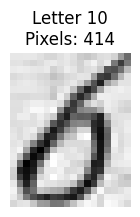

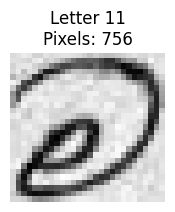

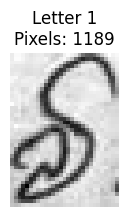

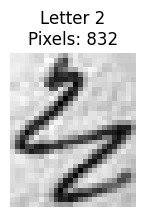

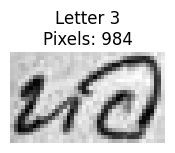

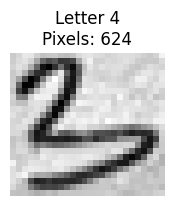

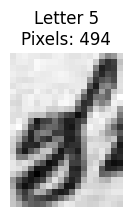

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/sentences.jpeg', cv2.IMREAD_GRAYSCALE)

# Invert the image so the text becomes white and the background becomes black
inverted_image = cv2.bitwise_not(image)

# Define a 3x3 kernel
kernel = np.ones((3, 3), np.uint8)

# Perform dilation on the inverted image
dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

# Invert back to original colors (if needed)
final_image = cv2.bitwise_not(dilated_image)

# Binarize the image with a higher threshold to reduce sensitivity
_, binary_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY_INV)

# Find contours for character segmentation
char_contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw bounding boxes
character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# List to store character bounding boxes
char_bounding_boxes = []
for contour in char_contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Filter out small contours to reduce noise
    if w > 10 and h > 20:
        char_bounding_boxes.append((x, y, w, h))

# Step 1: Sort by Y-coordinate (top to bottom) first to group lines
char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

# Step 2: Group contours that are on the same line based on their y-coordinates
line_threshold = 20  # Adjust this based on the spacing between lines
lines = []
current_line = []
previous_y = char_bounding_boxes[0][1]  # Initialize with the y-coordinate of the first contour

for box in char_bounding_boxes:
    x, y, w, h = box
    if abs(y - previous_y) < line_threshold:
        current_line.append(box)  # Same line
    else:
        lines.append(current_line)  # Start a new line
        current_line = [box]
    previous_y = y

# Add the last line
if current_line:
    lines.append(current_line)

# Step 3: Sort each line's bounding boxes by X-coordinate (left to right)
for line in lines:
    line.sort(key=lambda box: box[0])

# Step 4: Draw bounding boxes and print letters in the correct order
for line in lines:
    for (x, y, w, h) in line:
        # Draw character bounding boxes in blue
        cv2.rectangle(character_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the image with bounding boxes around characters
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
plt.title('Character Segmentation')
plt.axis('off')
plt.show()

# Step 5: Crop and display each letter in the correct order (left-to-right, top-to-bottom)
for line in lines:
    for i, (x, y, w, h) in enumerate(line):
        # Crop the letter from the original image
        letter_crop = image[y:y+h, x:x+w]
        
        # Calculate number of pixels in the cropped region
        num_pixels = np.sum(letter_crop > 0)  # Count non-zero pixels
        
        # Display the cropped letter with the number of pixels
        plt.figure(figsize=(2, 2))
        plt.imshow(letter_crop, cmap='gray')
        plt.title(f'Letter {i+1}\nPixels: {num_pixels}')
        plt.axis('off')
        plt.show()


#### Trial 02: With a Bigger Set of Letters - Successful!!

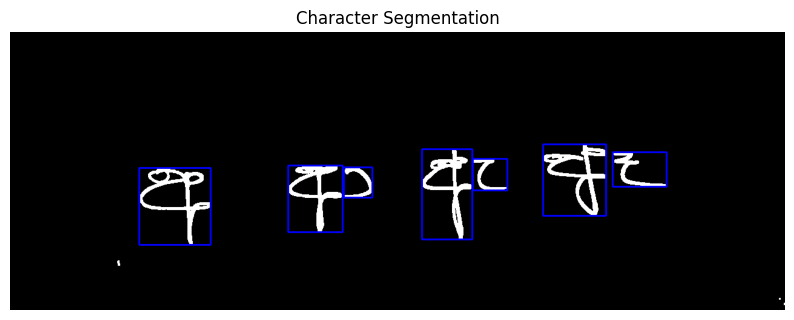

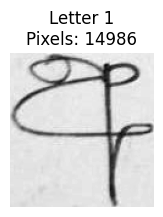

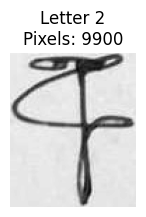

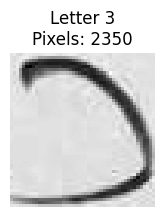

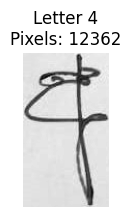

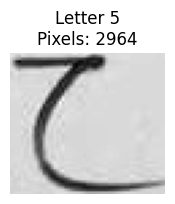

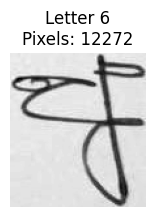

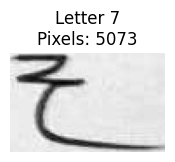

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/letters.jpg', cv2.IMREAD_GRAYSCALE)

# Invert the image so the text becomes white and the background becomes black
inverted_image = cv2.bitwise_not(image)

# Define a 3x3 kernel
kernel = np.ones((3, 3), np.uint8)

# Perform dilation on the inverted image
dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

# Invert back to original colors (if needed)
final_image = cv2.bitwise_not(dilated_image)

# Binarize the image with a higher threshold to reduce sensitivity
_, binary_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY_INV)

# Find contours for character segmentation
char_contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw bounding boxes
character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# List to store character bounding boxes
char_bounding_boxes = []
for contour in char_contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Filter out small contours to reduce noise
    if w > 10 and h > 10:
        char_bounding_boxes.append((x, y, w, h))

# Step 1: Sort by Y-coordinate (top to bottom) first to group lines
char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

# Step 2: Group contours that are on the same line based on their y-coordinates
line_threshold = 20  # Adjust this based on the spacing between lines
lines = []
current_line = []
previous_y = char_bounding_boxes[0][1]  # Initialize with the y-coordinate of the first contour

for box in char_bounding_boxes:
    x, y, w, h = box
    if abs(y - previous_y) < line_threshold:
        current_line.append(box)  # Same line
    else:
        lines.append(current_line)  # Start a new line
        current_line = [box]
    previous_y = y

# Add the last line
if current_line:
    lines.append(current_line)

# Step 3: Sort each line's bounding boxes by X-coordinate (left to right)
for line in lines:
    line.sort(key=lambda box: box[0])

# Step 4: Draw bounding boxes and print letters in the correct order
for line in lines:
    for (x, y, w, h) in line:
        # Draw character bounding boxes in blue
        cv2.rectangle(character_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the image with bounding boxes around characters
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
plt.title('Character Segmentation')
plt.axis('off')
plt.show()

# Step 5: Crop and display each letter in the correct order (left-to-right, top-to-bottom)
for line in lines:
    for i, (x, y, w, h) in enumerate(line):
        # Crop the letter from the original image
        letter_crop = image[y:y+h, x:x+w]
        
        # Calculate number of pixels in the cropped region
        num_pixels = np.sum(letter_crop > 0)  # Count non-zero pixels
        
        # Display the cropped letter with the number of pixels
        plt.figure(figsize=(2, 2))
        plt.imshow(letter_crop, cmap='gray')
        plt.title(f'Letter {i+1}\nPixels: {num_pixels}')
        plt.axis('off')
        plt.show()


## 04. Extract, Store, and Display Resized 80x80 Characters in the Correct Order - SUCCESS!!

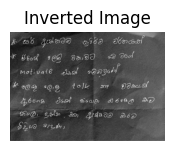

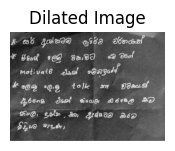

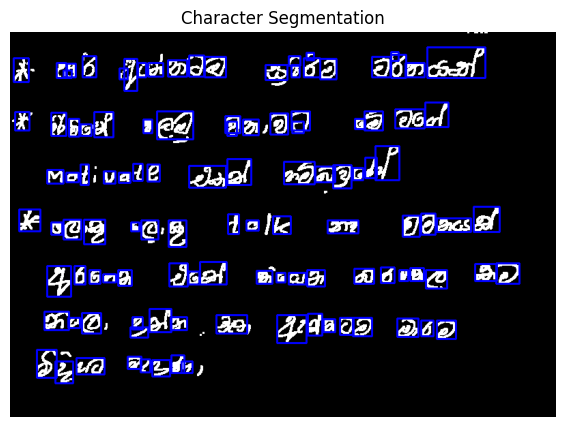

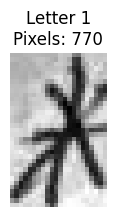

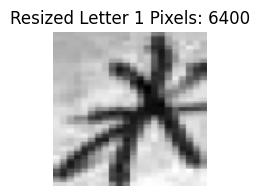

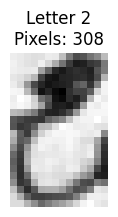

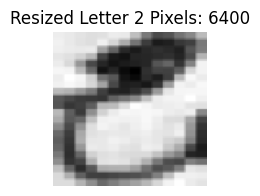

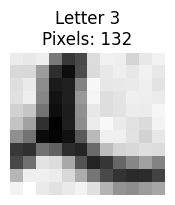

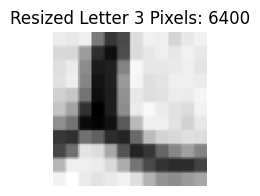

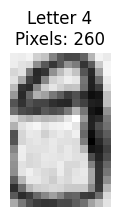

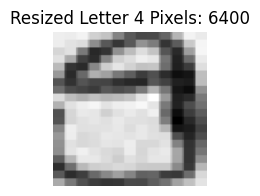

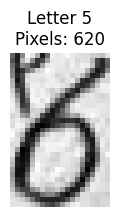

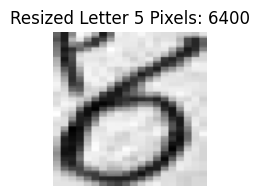

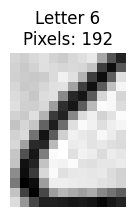

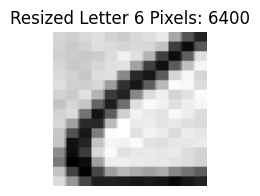

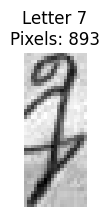

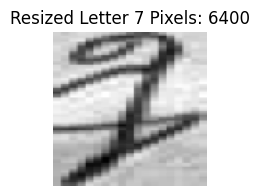

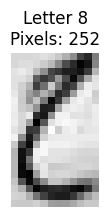

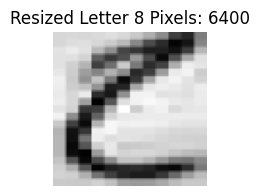

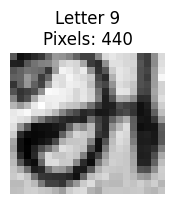

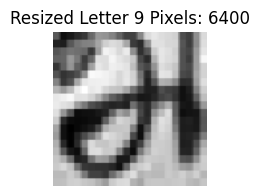

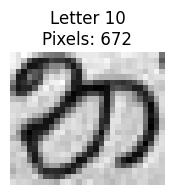

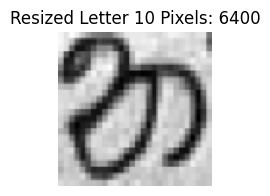

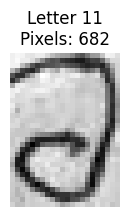

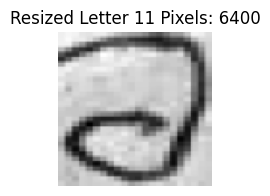

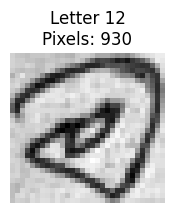

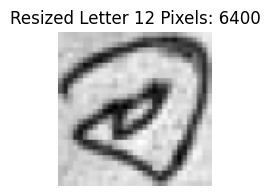

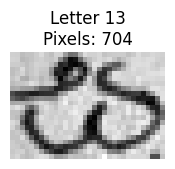

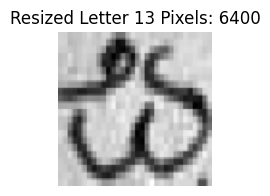

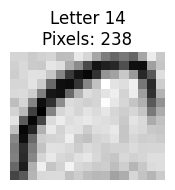

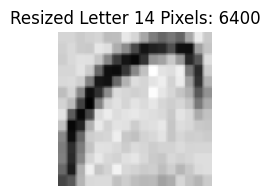

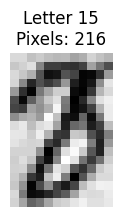

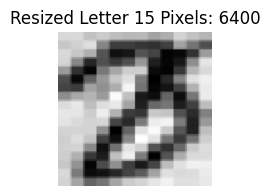

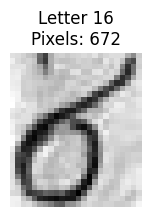

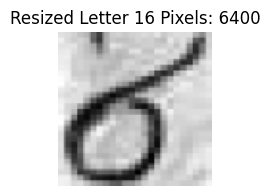

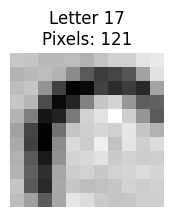

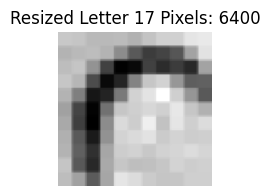

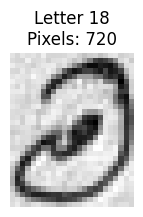

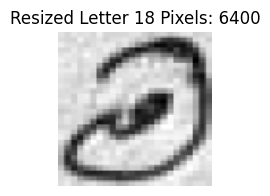

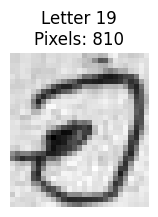

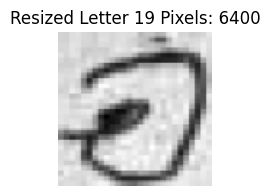

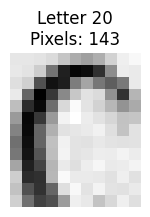

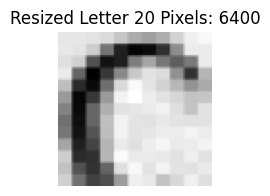

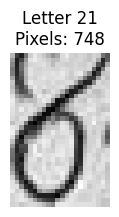

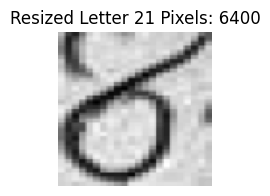

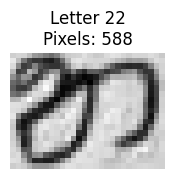

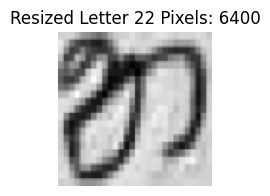

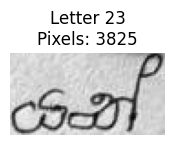

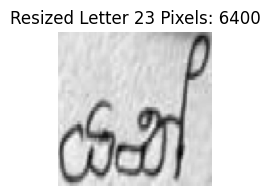

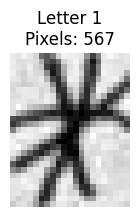

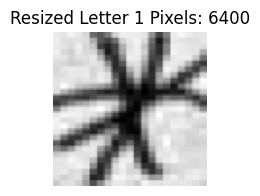

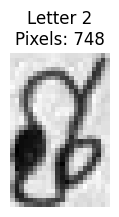

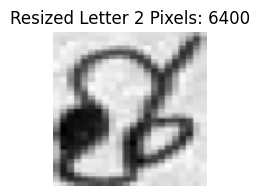

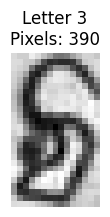

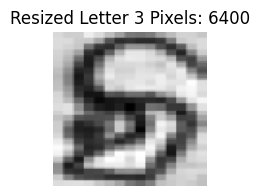

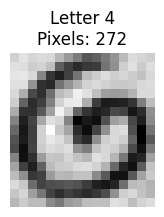

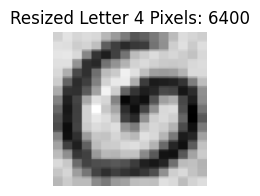

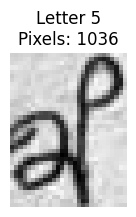

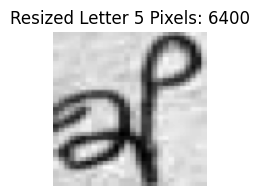

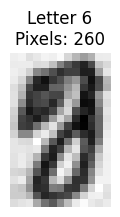

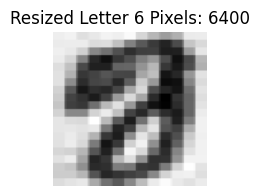

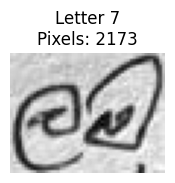

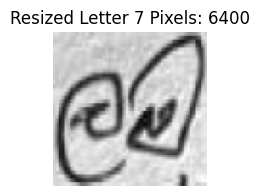

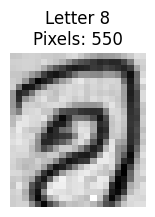

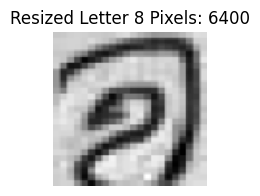

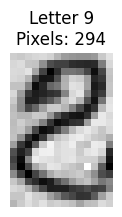

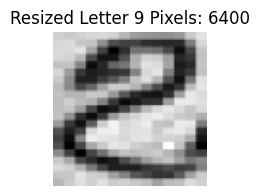

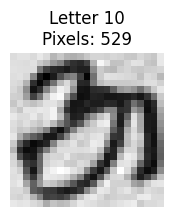

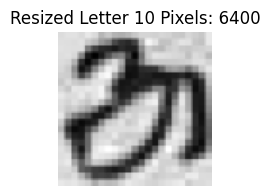

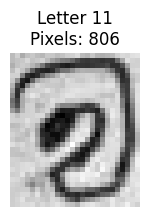

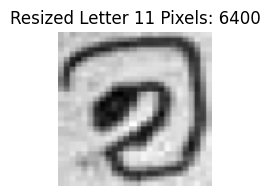

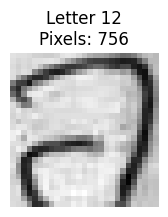

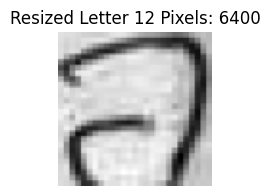

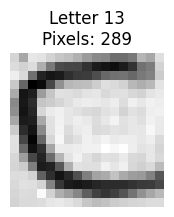

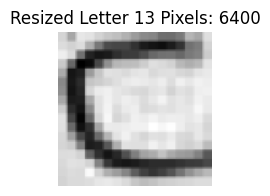

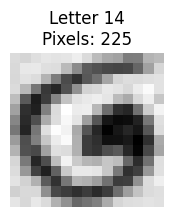

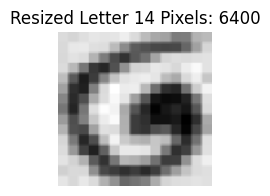

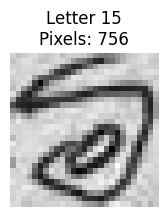

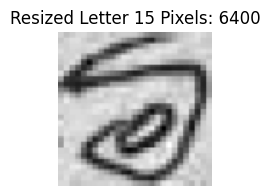

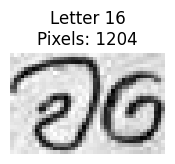

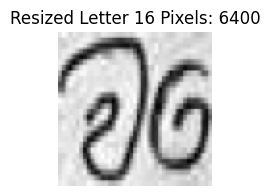

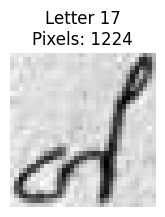

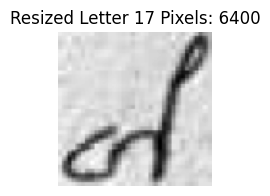

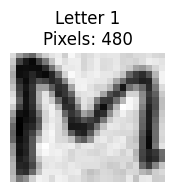

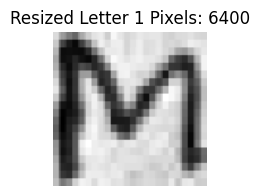

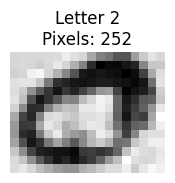

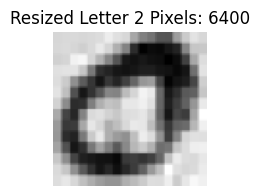

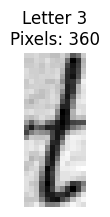

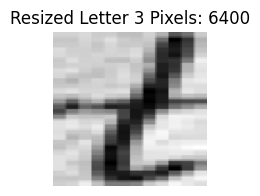

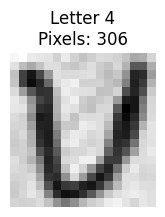

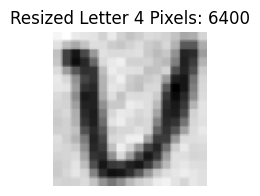

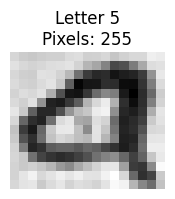

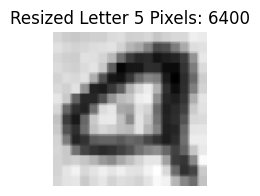

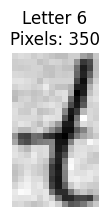

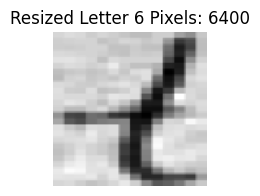

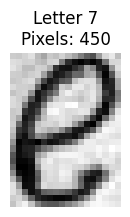

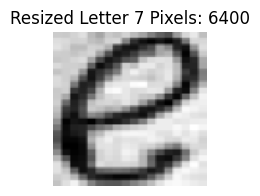

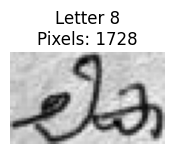

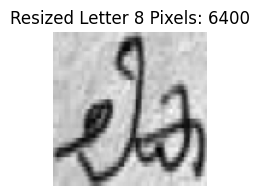

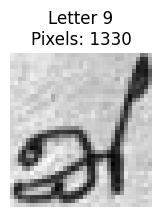

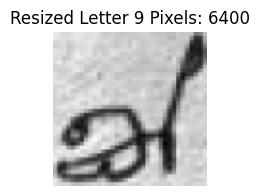

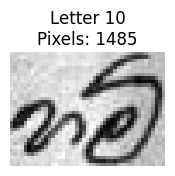

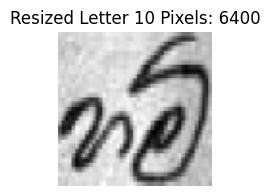

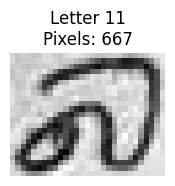

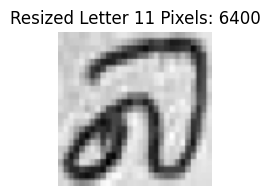

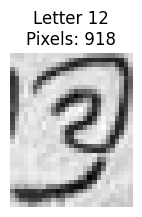

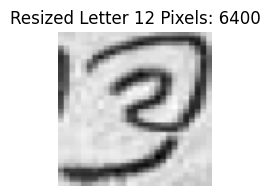

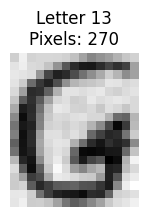

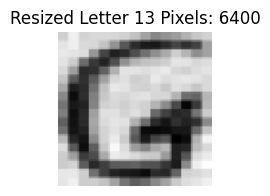

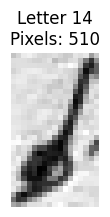

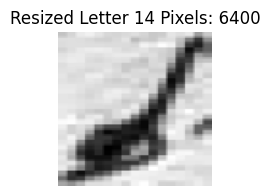

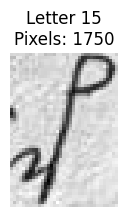

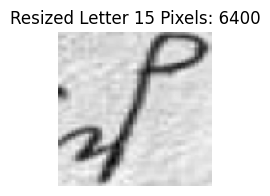

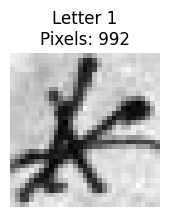

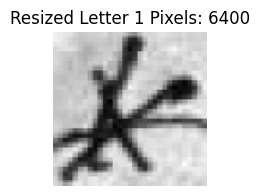

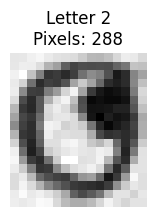

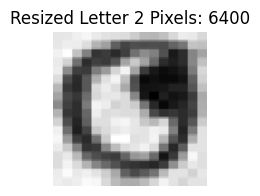

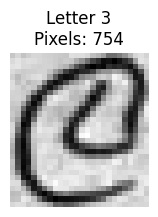

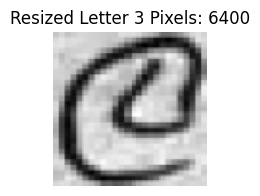

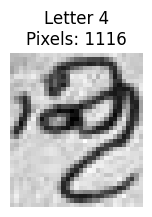

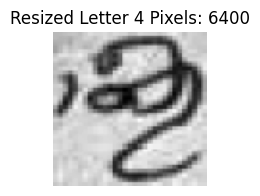

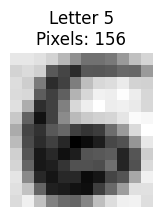

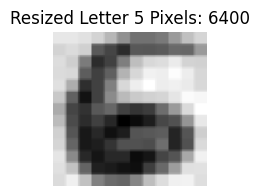

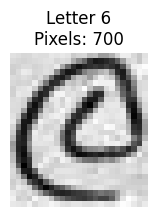

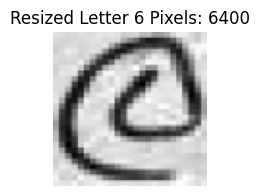

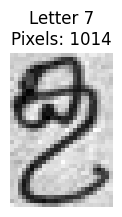

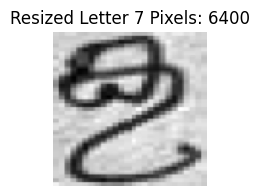

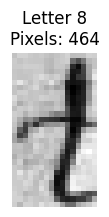

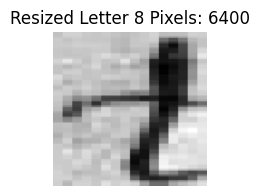

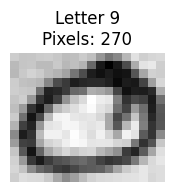

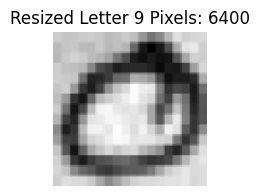

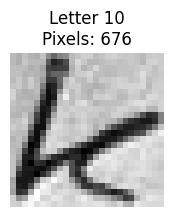

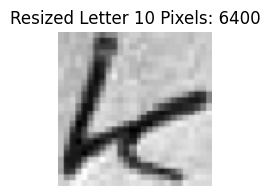

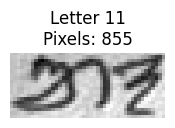

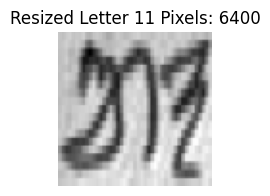

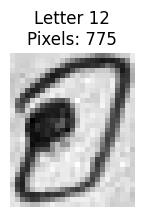

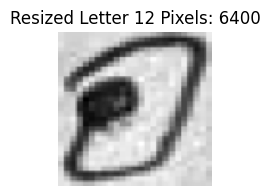

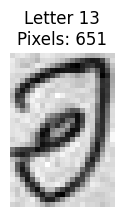

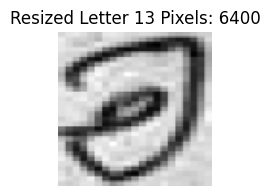

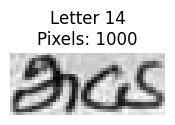

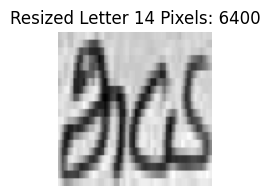

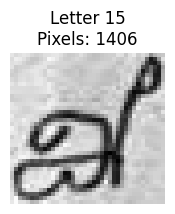

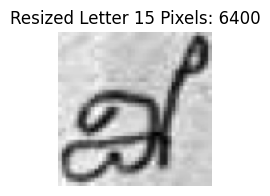

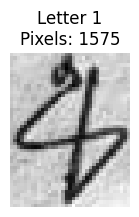

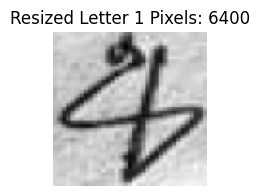

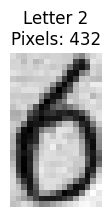

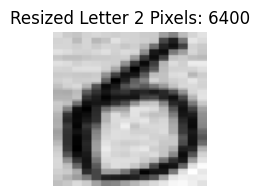

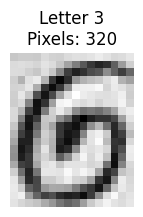

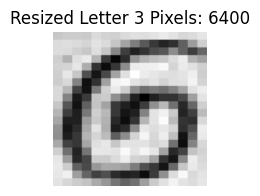

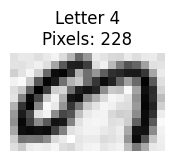

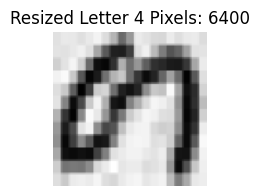

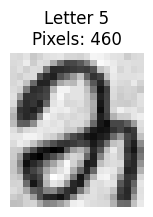

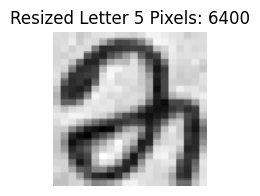

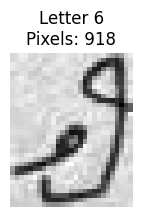

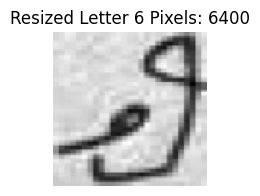

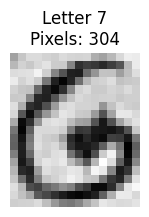

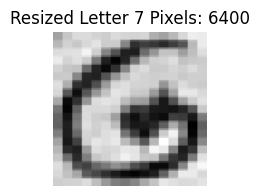

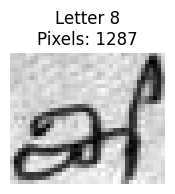

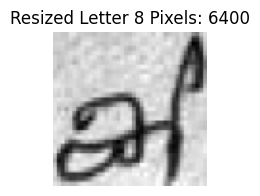

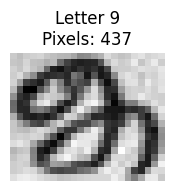

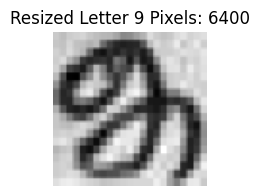

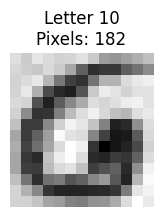

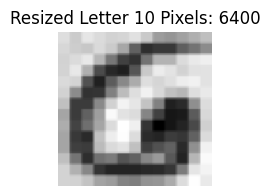

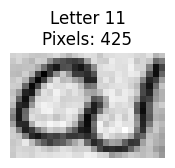

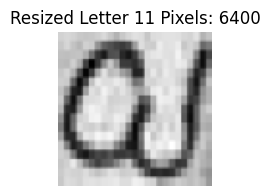

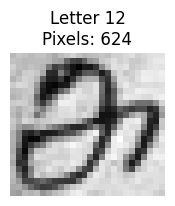

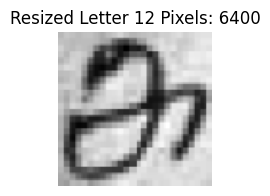

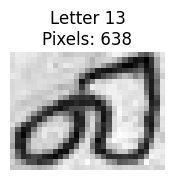

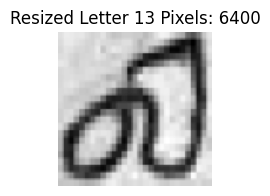

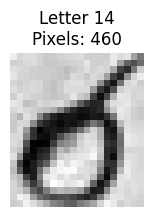

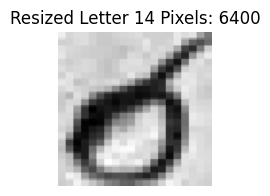

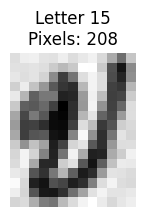

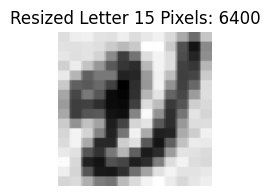

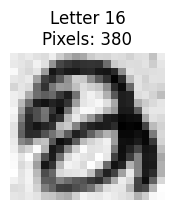

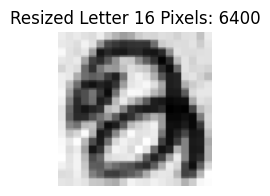

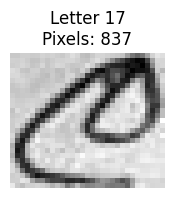

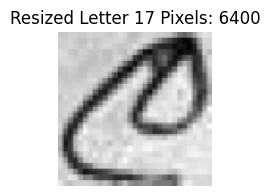

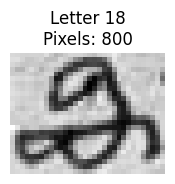

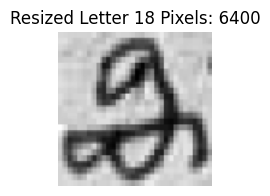

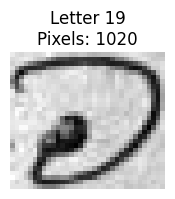

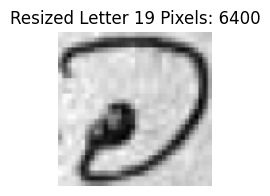

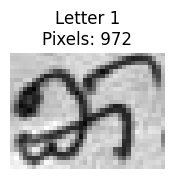

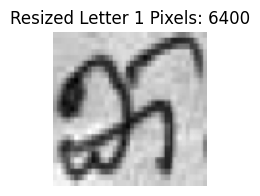

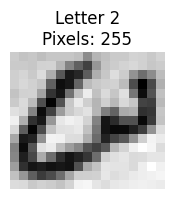

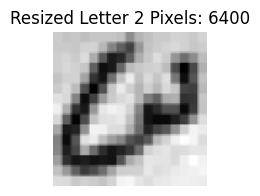

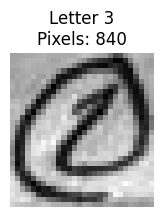

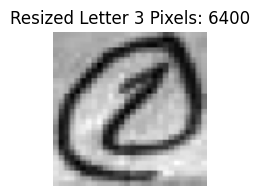

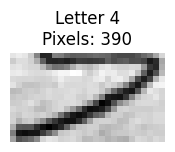

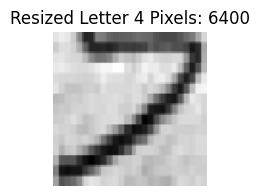

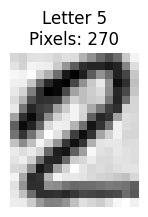

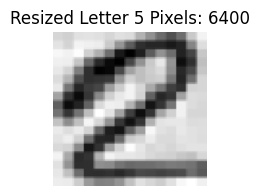

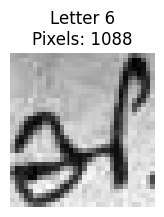

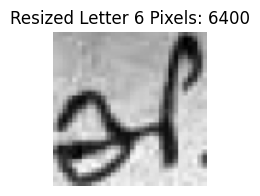

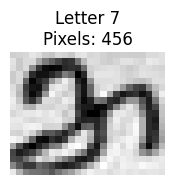

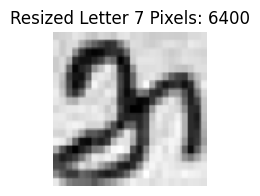

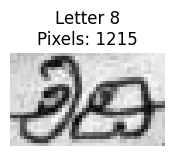

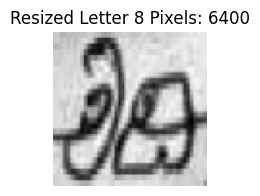

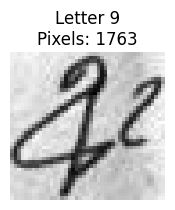

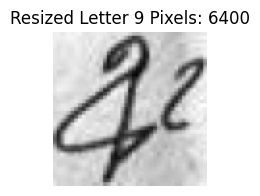

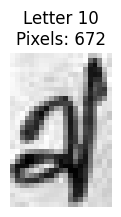

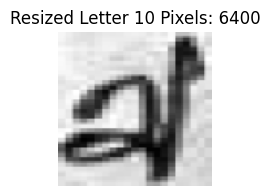

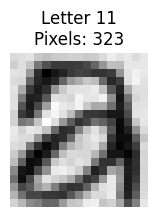

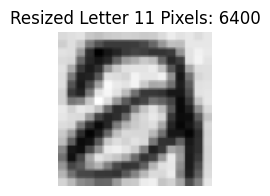

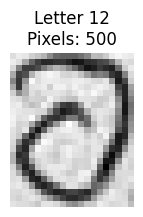

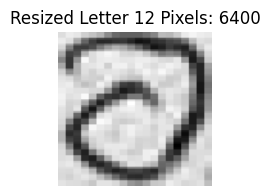

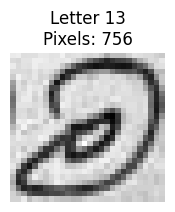

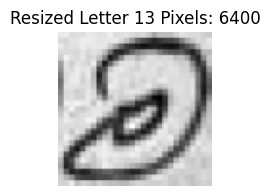

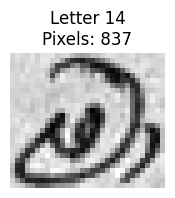

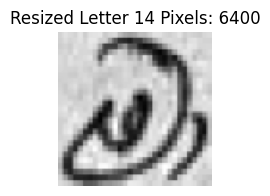

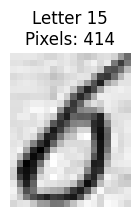

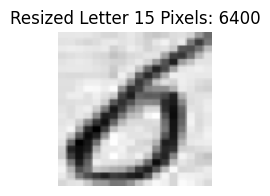

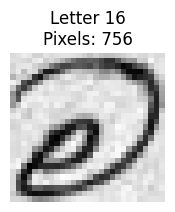

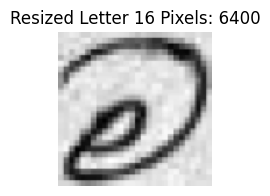

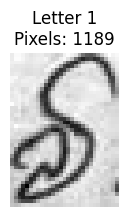

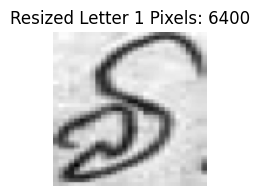

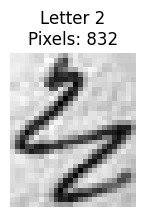

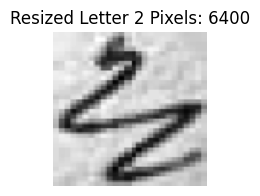

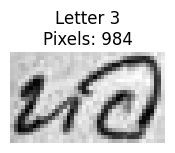

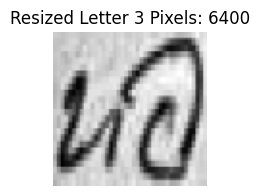

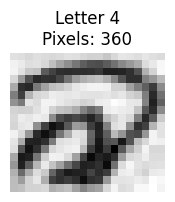

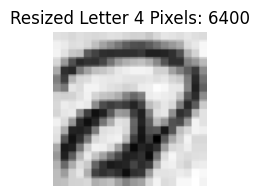

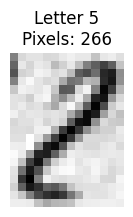

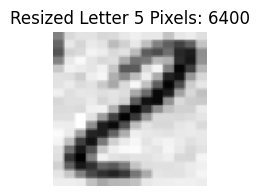

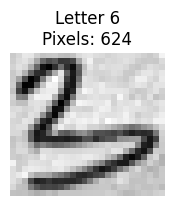

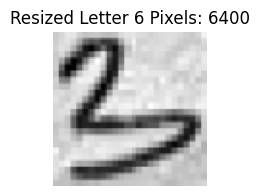

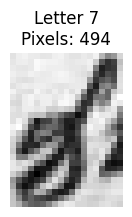

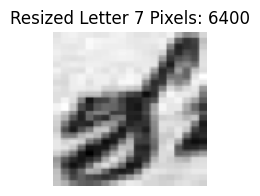

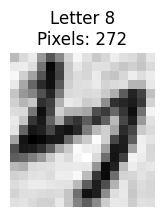

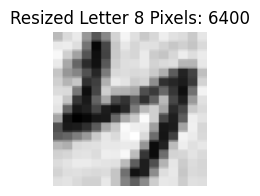

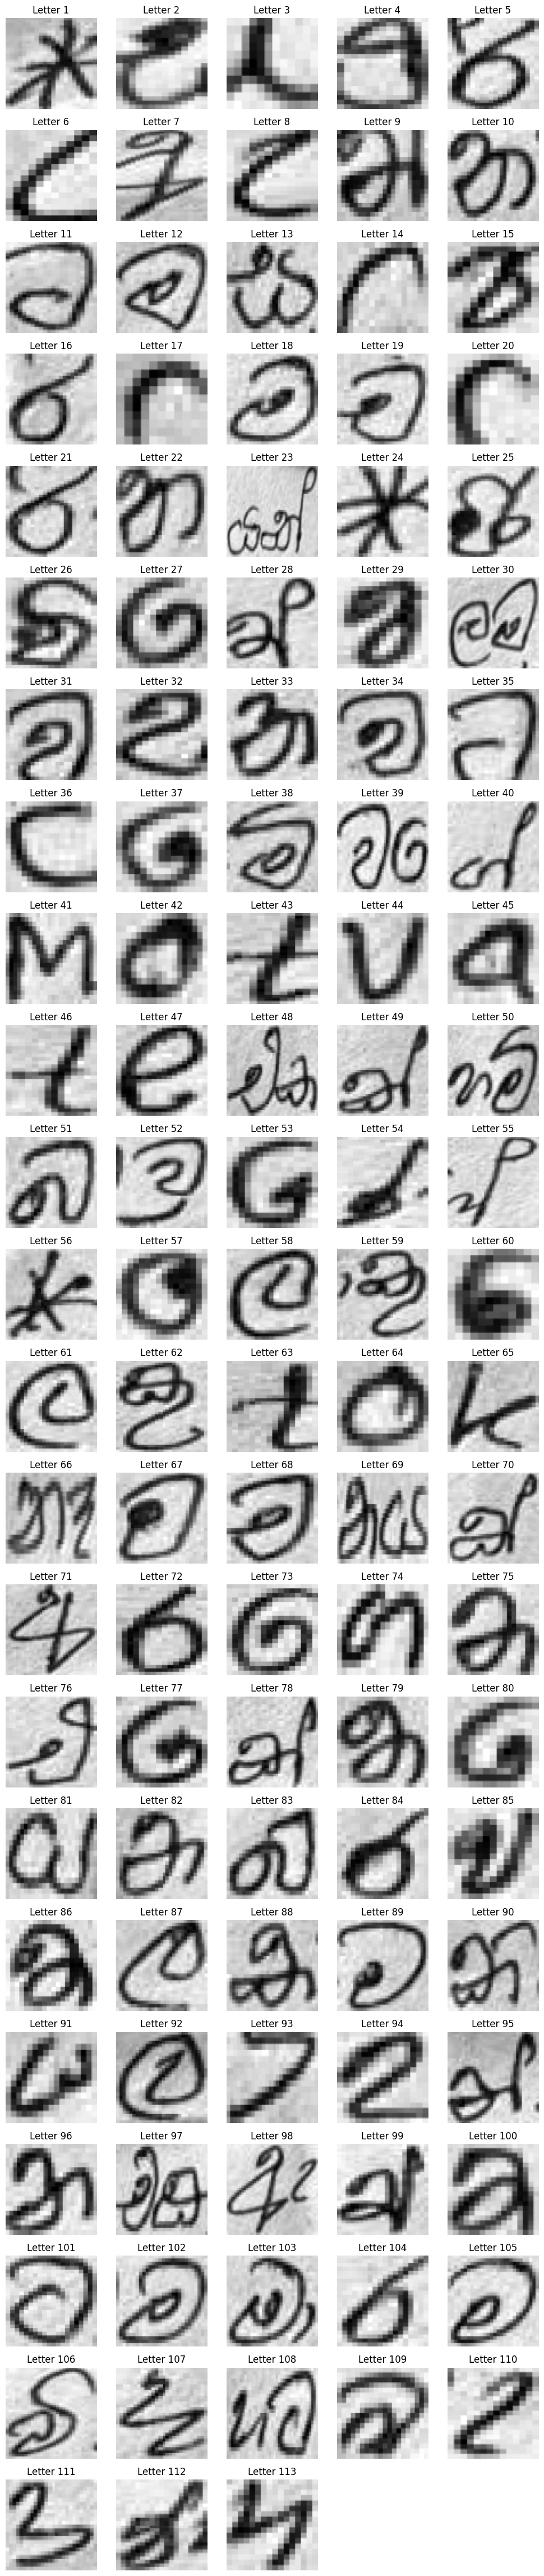

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/amma_cropped.jpg', cv2.IMREAD_GRAYSCALE)

# Invert the image so the text becomes white and the background becomes black
inverted_image = cv2.bitwise_not(image)

# Define a 3x3 kernel
kernel = np.ones((3, 3), np.uint8)

# Display the inverted image
plt.figure(figsize=(2, 2))
plt.imshow(inverted_image, cmap='gray')
plt.title(f'Inverted Image')
plt.axis('off')
plt.show()

# Perform dilation on the inverted image
dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

# Display the dialated 
plt.figure(figsize=(2, 2))
plt.imshow(dilated_image, cmap='gray')
plt.title(f'Dilated Image')
plt.axis('off')
plt.show()

# Invert back to original colors (if needed)
final_image = cv2.bitwise_not(dilated_image)

# Binarize the image with a higher threshold to reduce sensitivity
_, binary_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY_INV)

# Find contours for character segmentation
char_contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the image to draw bounding boxes
character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# List to store character bounding boxes
char_bounding_boxes = []
for contour in char_contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Filter out small contours to reduce noise
    if w > 10 and h > 10:
        char_bounding_boxes.append((x, y, w, h))

# Step 1: Sort by Y-coordinate (top to bottom) first to group lines
char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

# Step 2: Group contours that are on the same line based on their y-coordinates
line_threshold = 20  # Adjust this based on the spacing between lines
lines = []
current_line = []
previous_y = char_bounding_boxes[0][1]  # Initialize with the y-coordinate of the first contour

for box in char_bounding_boxes:
    x, y, w, h = box
    if abs(y - previous_y) < line_threshold:
        current_line.append(box)  # Same line
    else:
        lines.append(current_line)  # Start a new line
        current_line = [box]
    previous_y = y

# Add the last line
if current_line:
    lines.append(current_line)

# Step 3: Sort each line's bounding boxes by X-coordinate (left to right)
for line in lines:
    line.sort(key=lambda box: box[0])

# Step 4: Draw bounding boxes and print letters in the correct order
for line in lines:
    for (x, y, w, h) in line:
        # Draw character bounding boxes in blue
        cv2.rectangle(character_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the image with bounding boxes around characters
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
plt.title('Character Segmentation')
plt.axis('off')
plt.show()

# Function to display all letters stored in the resized_letters list
def display_letters(resized_letters):

    # Set up the figure for displaying multiple images
    num_letters = len(resized_letters)
    cols = 5  # Number of columns to display (you can change this based on how many images you want per row)
    rows = (num_letters + cols - 1) // cols  # Calculate number of rows needed
    plt.figure(figsize=(cols * 2, rows * 2))  # Set the figure size based on the number of images

    # Iterate through the list of resized letters and display each one
    for i, letter in enumerate(resized_letters):
        plt.subplot(rows, cols, i + 1)  # Create a subplot for each letter
        plt.imshow(letter, cmap='gray')
        plt.title(f'Letter {i+1}')
        plt.axis('off')  # Hide axis
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# List to hold the identified letters
resized_letters = []

# Step 5: Crop and display each letter in the correct order (left-to-right, top-to-bottom)
for line in lines:
    for i, (x, y, w, h) in enumerate(line):
        # Crop the letter from the original image
        letter_crop = image[y:y+h, x:x+w]
        
        # Calculate number of pixels in the cropped region
        num_pixels = np.sum(letter_crop > 0)  # Count non-zero pixels
        
        # Display the cropped letter with the number of pixels
        plt.figure(figsize=(2, 2))
        plt.imshow(letter_crop, cmap='gray')
        plt.title(f'Letter {i+1}\nPixels: {num_pixels}')
        plt.axis('off')
        plt.show()

        # Resize the cropped letter to 80x80 pixels
        resized_letter = cv2.resize(letter_crop, (80, 80), interpolation=cv2.INTER_AREA)

        # Append the hence resized letter to the resized_letters list. (To be fed into the google translator api lator on)
        resized_letters.append(resized_letter)

        # calculate the number of pixels in the resized region 
        num_pixels_resized = np.sum(resized_letter > 0) # Count non-zero pixels

        # Display the resized letter 
        plt.figure(figsize=(2, 2))
        plt.imshow(resized_letter, cmap='gray')
        plt.title(f'Resized Letter {i+1} Pixels: {num_pixels_resized}')
        plt.axis('off')
        plt.show()

# Call the function with the list of resized letters
display_letters(resized_letters)